In [1]:
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from utils import *
from simulator import Simulator

In [2]:
sim = Simulator()
sim.logger.setLevel(logging.DEBUG)

In [3]:
fundamentals = pd.read_hdf('jqstorage.h5', 'fundamentals')

##  特征扩展

In [4]:
import featuretools as ft

In [5]:
from featuretools.primitives import make_agg_primitive, make_trans_primitive
from featuretools.variable_types import Numeric

def divide(a, b):
    return a / b

def subtract(a, b):
    return a - b

Divide = make_trans_primitive(function=divide, input_types=[Numeric, Numeric], return_type=Numeric)
Subtract = make_trans_primitive(function=subtract, input_types=[Numeric, Numeric], return_type=Numeric)

In [6]:
es = ft.EntitySet(id='fundamentals')

In [7]:
es = es.entity_from_dataframe(entity_id='fundamentals', dataframe = fundamentals, make_index=True, index='index')

In [8]:
features, feature_names = ft.dfs(entityset = es, target_entity = 'fundamentals', 
                                agg_primitives = [], trans_primitives = [Divide, Subtract], max_depth = 1,
                                ignore_variables = {'fundamentals': ['code', 'date']})

In [9]:
features['code'] = fundamentals['code']
features['date'] = fundamentals['date']

In [10]:
feature_names

[<Feature: market_cap>,
 <Feature: pe_ratio>,
 <Feature: pb_ratio>,
 <Feature: turnover_ratio>,
 <Feature: pcf_ratio>,
 <Feature: ps_ratio>,
 <Feature: fixed_assets>,
 <Feature: total_assets>,
 <Feature: dividend_payable>,
 <Feature: basic_eps>,
 <Feature: total_operating_cost>,
 <Feature: total_operating_revenue>,
 <Feature: operating_profit>,
 <Feature: administration_expense>,
 <Feature: financial_expense>,
 <Feature: adjusted_profit>,
 <Feature: value_change_profit>,
 <Feature: inc_return>,
 <Feature: roa>,
 <Feature: roe>,
 <Feature: DIVIDE(inc_return, market_cap)>,
 <Feature: DIVIDE(roe, market_cap)>,
 <Feature: DIVIDE(pb_ratio, adjusted_profit)>,
 <Feature: DIVIDE(fixed_assets, total_operating_revenue)>,
 <Feature: DIVIDE(roa, total_operating_revenue)>,
 <Feature: DIVIDE(total_operating_cost, roe)>,
 <Feature: DIVIDE(administration_expense, inc_return)>,
 <Feature: DIVIDE(total_operating_cost, operating_profit)>,
 <Feature: DIVIDE(pcf_ratio, pb_ratio)>,
 <Feature: DIVIDE(pe_rati

## 单因子测试

In [11]:
def single_factor_test(factor, sim, points):
    history_asset = {}
    for part in range(1, 6):
        history_asset[part] = []
        sim.reset()
        for date in points:
            sim.date = date
            df = features[features.date==date][['code', factor]]
            df = df.sort_values(factor, ascending=False)
            df = df[~df[factor].isnull()]
            securities = df['code'][df.shape[0]//5*(part-1):df.shape[0]//5*part]
            for security in sim.stock:
                if sim.stock[security] > 0:
                    sim.order_target(security, 0)
            asset = sim.cash
            for security in securities.values:
                sim.order_value(security, asset/len(securities.values))
            history_asset[part].append(sim.get_asset())
    df=pd.DataFrame.from_dict(history_asset, orient='index')
    df.columns=points
    return df

In [12]:
def plot_history_asset(history_asset, factor, bench_asset=None):
    plt.figure(figsize=(10,5))
    plt.title('{}'.format(factor))
    for part in history_asset.index:
        plt.plot(history_asset.columns, history_asset.loc[part])
    legends = list(history_asset.index)
    if bench_asset is not None:
        plt.fill_between(points, bench_asset.loc['bench'], plt.gca().get_ylim()[0], alpha=0.3)
        legends.append('bench')
    plt.legend(legends)

In [77]:
def calc_validity(history_asset, start_cash, bench_asset):
    benefit = (history_asset-start_cash)/start_cash
    bench_benefit = (bench_asset-start_cash)/start_cash
    corr = np.corrcoef(benefit.iloc[:, -1], benefit.index)[0, 1]
    AR1 = benefit.iloc[0,-1] - bench_benefit.iloc[-1,-1]
    ARn = benefit.iloc[-1,-1] - bench_benefit.iloc[-1,-1]
    win_prob1 = (benefit.iloc[0] > bench_benefit).sum(axis=1)[0]/len(benefit.columns)
    win_probn = (benefit.iloc[-1] > bench_benefit).sum(axis=1)[0]/len(benefit.columns)
    return corr, AR1, ARn, win_prob1, win_probn

In [14]:
# 计算基准收益
sim.reset()
points = [x[0] for x in get_sample_point()]
sim.date = points[0]
sim.order_value('000300.XSHG', sim.cash)
bench_asset = [sim.get_asset()]
for date in points[1:]:
    sim.date = date
    bench_asset.append(sim.get_asset())
bench_asset = pd.DataFrame.from_dict({'bench':bench_asset}, orient='index')
bench_asset.columns = points

## 计算所有指标的单因子有效性

In [ ]:
all_history_asset = {}
for factor in features.columns:
    if factor in ['code', 'date']:
        continue
    history_asset = single_factor_test(factor, sim, points)
    all_history_asset[factor] = history_asset
    print(factor, calc_corr(history_asset, sim.start_cash))
all_history_asset = pd.Panel(all_history_asset)
all_history_asset.to_hdf('jqstorage.h5', 'all_history_asset')

market_cap 0.7282263137572671
pe_ratio 0.09586107120918853
pb_ratio -0.4766706372164836
turnover_ratio 0.7280671805050309
pcf_ratio 0.2174185615063067
ps_ratio -0.2615302952025057
fixed_assets 0.8313011094201758
total_assets 0.7742825287994864
dividend_payable 0.4871216360859386
basic_eps -0.325566761115835
total_operating_cost 0.7080556633118602
total_operating_revenue 0.7109337316154357
operating_profit 0.7790941999138602
administration_expense 0.6908651479910393
financial_expense 0.6398648349892087
adjusted_profit 0.8302055012364683
value_change_profit 0.8567926800970075
inc_return 0.20106699370231598
roa -0.44715417016802517
roe 0.14929432587699407
DIVIDE(inc_return, market_cap) -0.6374708078903657
DIVIDE(roe, market_cap) -0.5873726480983891
DIVIDE(pb_ratio, adjusted_profit) -0.49907791693384357
DIVIDE(fixed_assets, total_operating_revenue) 0.04702025303365545
DIVIDE(roa, total_operating_revenue) -0.576933570330392
DIVIDE(total_operating_cost, roe) 0.8554384163896431
DIVIDE(adminis

In [80]:
validity = {}
for factor in all_history_asset:
    validity[factor] = calc_validity(all_history_asset[factor], sim.start_cash, bench_asset)

In [83]:
validity = pd.DataFrame.from_dict(validity, orient='index')
validity.columns = ['corr', 'AR1', 'ARn', 'win_prob1', 'win_probn']

In [120]:
MinCorr = 0.5
MinAR1 = 0.3
MinARn = -0.2
MinWin_prob1 = 0.8
MinWin_probn = 0.1
validity[(abs(validity['corr'])>MinCorr) & 
         (((validity['AR1']>MinAR1) & (validity['ARn']<MinARn)) | ((validity['ARn']>MinAR1) & (validity['AR1']<MinARn))) &
         (((validity['win_prob1']>MinWin_prob1) & (validity['win_probn']<MinWin_probn)) |
         ((validity['win_probn']>MinWin_prob1) & (validity['win_prob1']<MinWin_probn)))]

,corr,AR1,ARn,win_prob1,win_probn
"DIVIDE(adjusted_profit, basic_eps)",0.924211,-0.233398,0.444362,0.033333,0.900000
"DIVIDE(adjusted_profit, roa)",0.877770,-0.228754,0.467029,0.033333,0.900000
"DIVIDE(basic_eps, dividend_payable)",-0.920575,0.430934,-0.280204,0.900000,0.000000
"DIVIDE(dividend_payable, basic_eps)",0.952678,-0.222034,0.300614,0.000000,0.900000
"DIVIDE(dividend_payable, roa)",0.896196,-0.219547,0.311796,0.066667,0.900000
"DIVIDE(inc_return, dividend_payable)",-0.900443,0.419356,-0.239137,0.900000,0.000000
"DIVIDE(market_cap, basic_eps)",0.945140,-0.300831,0.490608,0.033333,0.900000
"DIVIDE(market_cap, roa)",0.862794,-0.216225,0.638041,0.066667,0.933333
"DIVIDE(market_cap, roe)",0.858021,-0.201373,0.538628,0.066667,0.933333
"DIVIDE(operating_profit, roa)",0.840750,-0.213107,0.523036,0.033333,0.900000


In [122]:
validity.loc['DIVIDE(fixed_assets, total_assets)']

corr        -0.466426
AR1         -0.141604
ARn         -0.219109
win_prob1    0.000000
win_probn    0.333333
Name: DIVIDE(fixed_assets, total_assets), dtype: float64

In [127]:
sim.reset()
sim.logger.setLevel(logging.INFO)

factor = 'SUBTRACT(financial_expense, fixed_assets)'
# factor = 'DIVIDE(basic_eps, total_assets)'
history_asset = single_factor_test(factor, sim, points)

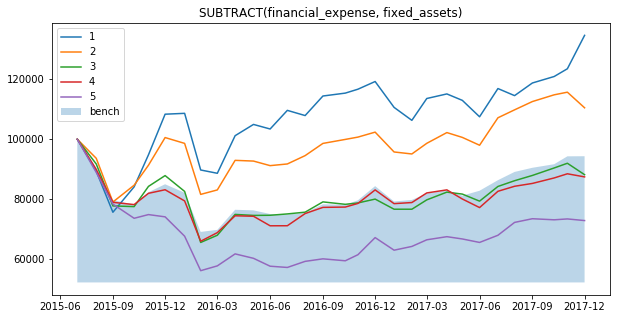

In [128]:
%matplotlib inline
plot_history_asset(history_asset, factor, bench_asset)